# Deep feedforward neural network

## Import some very basic library we need

In [3]:
#import numpy as np
import os
import autograd.numpy as np
from autograd import value_and_grad
from autograd.misc.flatten import flatten_func
from autograd import grad as compute_grad
import matplotlib.pyplot as plt


# import custom utilities and plotter
import custom_plotter as plotter

## Algorithm: Gradient descent algorithm (first order method)

In [4]:
#can deal with the complex form of weight w
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist


## Model(architecture): FNN（fully connected layers/ MPLs）

In [8]:
#deep feedforward neural network/MLPs, here we use the efficient way to compute the feedforward neural network, that is to use
#the version of total dataset x as input.

# choose a nonlinear activation function 
def activation(t):
    # a relu function
    ## nonlinearity = np.maximum(0,t)  # you can choose a relu function
    
    # a tanh function
    nonlinearity = np.tanh(t)
    return nonlinearity

# fully evaluate our network features using the tensor of weights in omega_inner
def compute_features(x, omega_inner):
    o = np.ones((np.shape(x)[0],1))# add 1 to every dataset, o = P*1
    a_padded = np.concatenate((o,x),axis = 1) #according the axis = 1 to concatenate all dataset, a_padded = P*(N+1),array
    
    # loop through each layer matrix
    for W in omega_inner:
        # output of layer activation
        a = activation(np.dot(a_padded,W)) #in the first loop, P*(N+1) dot (N+1)*U_1, we get P*U_1, that means we compute all the dataset at once.
                
        #  pad with ones (to compactly take care of bias) for next layer computation
        o = np.ones((np.shape(a)[0],1))#continue to add 1 to every array.
        a_padded = np.concatenate((o,a),axis = 1) #combine as the new input.
        
    return a_padded #finally we get P*(U_L + 1), every array will dot w.

# our predict function 
def predict(x,omega):     
    # compute network features - here omega[0] contains the entire tensor of internal weights
    f = compute_features(x,omega[0]) #totally, P datasets, every dataset is a array, containing{1,f_1,...,f_n}
    
    # compute linear model compactly via inner product - here omega[1] contains only those weights in the final linear combination of network features
    vals = np.dot(f,omega[1]) #P*(1 + U_L) dot (1+U_L) * 1
    return vals #P * 1

# define the least squares cost function
least_squares = lambda w: np.sum((predict(x,w) - y)**2)

# define the two_classification softmax function 
softmax = lambda w: np.sum(np.log(1 + np.exp(-y*predict(x,w))))
count = lambda w: 0.25*np.sum((np.sign(predict(x,w)) - y)**2)# label should be 1 , -1


# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes,scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k + 1,U_k_plus_1)
        weights.append(weight)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init[1] = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

## 1. Example of two-classification on toy data
Using a nonlinear toy dataset to perform two-classification by a simple deep forward network

### load toy data

In [9]:
# data input
csvname = './datasets/bricks.csv'
data = np.loadtxt(csvname,delimiter = ',')

x = data[:,:-1]#shape P*N, w dimensions.
y = data[:,-1:]#shape P*M
print('data structure:' , np.shape(x), 'datapoints_numbers,datapoints_dimensions')
print('data structure:' , np.shape(y), 'datapoints_numbers,labels_dimensions')

data structure: (100, 2) datapoints_numbers,datapoints_dimensions
data structure: (100, 1) datapoints_numbers,labels_dimensions


### plot toy data

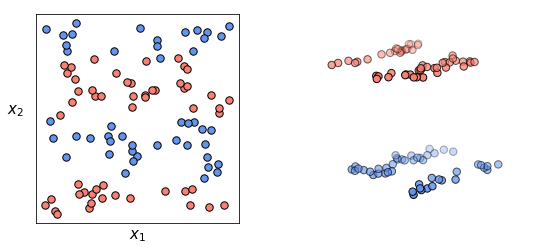

In [16]:
plotter_demo = plotter.Visualizer()
plotter_demo.plot_classification_data(x,y)

### initialize weights

In [10]:
#initialize weights

# An example 4 hidden layer network, with 10 units in each layer
N = np.shape(x)[1] #there are N features of input x
M = np.shape(y)[1] #there are M dimensions of output y
U_1 = 10
U_2 = 10
U_3 = 10

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

scale = 0.5
w_init = initialize_network_weights(layer_sizes,scale)

### Training

In [11]:
#compute the weight_history, training.
weight_history = gradient_descent(g = softmax ,w = w_init ,alpha = 10**(-2),max_its = 500,beta = 0.8,version = 'normalized')
softmax_history = [softmax(v) for v in weight_history]
count_history = [count(v) for v in weight_history]

### Plot training result

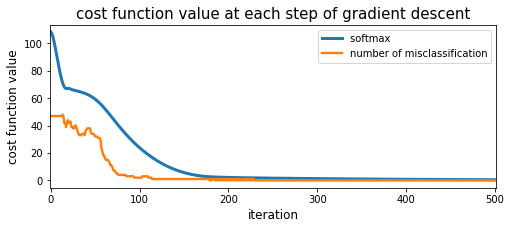

In [12]:
# plot cost function history
start = 0   # at which iteration to begin plotting the cost function history
cost_histories = [softmax_history,count_history]

labels = ['softmax ','number of misclassification']
plotter_demo.compare_regression_histories(cost_histories,start = start,labels = labels)

### Get the tuned weights

In [20]:
# extract the best weights of network over our training data
best_ind = np.argmin(count_history)
w_best = weight_history[best_ind]

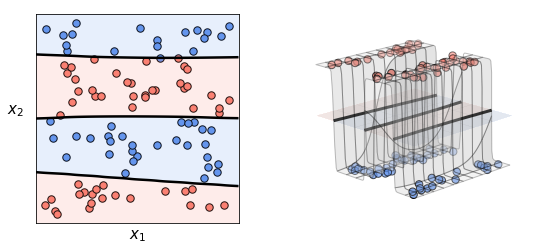

In [22]:
# plot the dataset along with classification boundary (in the left panel) and corresponding surface fit (in the right panel)
plotter_demo.plot_classification_data(x,y,predict = predict,weights = w_best)

## 2. Example of two-classification on toy data

In [169]:
# data input
csvname = './datasets/2_eggs.csv'
data = np.loadtxt(csvname,delimiter = ',')

x = data[:,:-1]#shape P*N, w dimensions.
y = data[:,-1:]#shape P*M
print('data structure:' , np.shape(x), 'datapoints_numbers,datapoints_dimensions')
print('data structure:' , np.shape(y), 'datapoints_numbers,labels_dimensions')

data structure: (96, 2) datapoints_numbers,datapoints_dimensions
data structure: (96, 1) datapoints_numbers,labels_dimensions


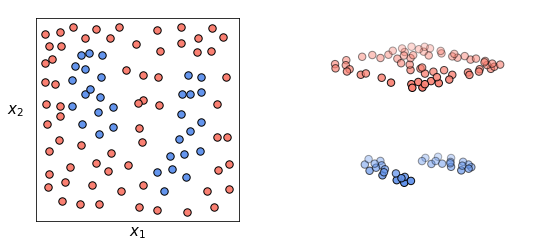

In [170]:
plotter_demo = plotter.Visualizer()
plotter_demo.plot_classification_data(x,y)

In [187]:
#initialize weights

# An example 5 hidden layer network
N = np.shape(x)[1] #there are N features of input x
M = np.shape(y)[1] #there are M dimensions of output y
U_1 = 10
U_2 = 10
U_3 = 10
U_4 = 15

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,U_4,M]

scale = 0.5
w_init = initialize_network_weights(layer_sizes,scale)

In [188]:
#compute the weight_history, training.
weight_history = gradient_descent(g = softmax ,w = w_init ,alpha = 10**(-2),max_its = 500,beta = 0.8,version = 'normalized')
softmax_history = [softmax(v) for v in weight_history]
count_history = [count(v) for v in weight_history]

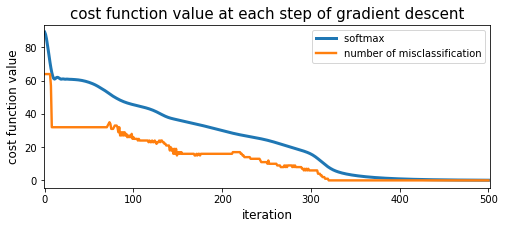

In [189]:
# plot cost function history
start = 0   # at which iteration to begin plotting the cost function history
cost_histories = [softmax_history,count_history]

labels = ['softmax ','number of misclassification']
plotter_demo.compare_regression_histories(cost_histories,start = start,labels = labels)

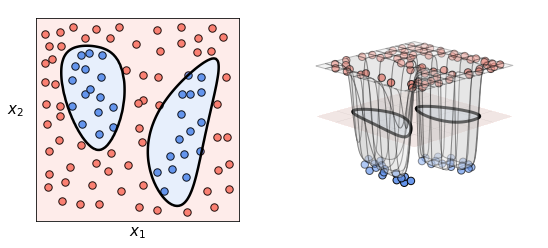

In [190]:
best_ind = np.argmin(count_history)
w_best = weight_history[best_ind]
# plot the dataset along with classification boundary (in the left panel) and corresponding surface fit (in the right panel)
plotter_demo.plot_classification_data(x,y,predict = predict,weights = w_best)

## 3.Example of multiple classifiction for E-Commerce data
Using a practical 5 dimensional dataset, about a market survey, which lable is to decide whether the customer will buy a product or not. There are 4 class lables: [0,1,2,3], each correspongdingly represents the customer's action:[bounce,add to cart, begin checkout,finish check out]. This dataset is a nonlinear four-class classification dataset. Using a deep feedforward network to perform classify and make prediction. There are total 500 datapoints.

In [145]:
# data input
csvname = './datasets/ecommerce_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

x = data[:-100,:-1]#shape P*N, 5 dimensions.
y = data[:-100,-1:]#shape P*M, C = 4
print('original data structure:')
print(x)
P,N = np.shape(x)
print(P,N,' :datapoins dimensions')

original data structure:
[[1.         0.         0.65750995 0.         3.        ]
 [1.         1.         0.56857123 0.         2.        ]
 [1.         0.         0.042246   1.         1.        ]
 ...
 [0.         2.         0.47901813 1.         3.        ]
 [0.         3.         0.10978449 0.         1.        ]
 [0.         0.         0.94495524 0.         2.        ]]
400 5  :datapoins dimensions


### Preprocess The Inputdata: normalization and one-hot

In [152]:
# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

def preprocess_data(x):
    
    P,N = np.shape(x)# P is # of datapoints, N is the dimensions.
    
    x_processed = np.zeros((P, N+3))#creat a new matrix to containing the processed data
    x_processed[:,0:(N-1)] = x[:,0:(N-1)]
    
    # compute the mean and standard deviation of our input, then normalize the input
    x_means = np.mean(x[:,1:3],axis = 0)
    x_stds = np.std(x[:,1:3],axis = 0)
    # normalize the 1th and 2th column of input data
    x_processed[:,1:3] = normalize(x[:,1:3],x_means,x_stds)
    
    #one_hot for the last column of the input data x. This processing can make 0,1,2,3 from one column to four column,
    #which means that the new 4 dimensions corresponding to the four column, their value is 0/1, 1 represents that
    #the customer visit the product during the corresponding time. 
    for n in range(N):
        t = int(x[n,N-1])
        x_processed[n,t+N-1] = 1
    
    return x_processed,x_means,x_stds

x_processed,x_means,x_stds = preprocess_data(x)
x = x_processed
print('processed data structure:')
print(x_processed)
print(np.shape(x_processed))

processed data structure:
[[ 1.         -0.82341543 -0.40991831 ...  0.          0.
   1.        ]
 [ 1.          0.12576662 -0.50550703 ...  0.          1.
   0.        ]
 [ 1.         -0.82341543 -1.07118597 ...  1.          0.
   0.        ]
 ...
 [ 0.          1.07494867 -0.60175608 ...  0.          0.
   0.        ]
 [ 0.          2.02413071 -0.99859758 ...  0.          0.
   0.        ]
 [ 0.         -0.82341543 -0.10098053 ...  0.          0.
   0.        ]]
(400, 8)


### Multiclass softmax cost function

In [129]:
# multiclass softmaax regularized by the summed length of all normal vectors
def multiclass_softmax(W):        
    # pre-compute predictions on all points
    all_evals = predict(x,W)

    # compute cost in compact form using numpy broadcasting
    a = np.log(np.sum(np.exp(all_evals),axis = 1)) 
    b = all_evals[np.arange(len(y)),y.astype(int).flatten()]
    cost = np.sum(a - b)
    return cost#/float(len(y))
    
    # fusion rule for counting number of misclassifications on an input multiclass dataset
def fusion_rule(W):
    # pre-compute predictions on all points
    all_evals = predict(x,W)

    # create predicted labels
    y_predict = np.argmax(all_evals,axis = 1)

    return y_predict
    
def multiclass_miss_count(W):
    # make predictions
    y_predict = fusion_rule(W)
        
    # compare to actual labels
    misclassifications = int(sum([abs(np.sign(a - b)) for a,b in zip(y,y_predict)]))
        
    return misclassifications

In [130]:
# A 5 layer network architecture
N = np.shape(x)[1]
C = 4
U_1 = 10                # number of units in layer 1
U_2 = 10                # number of units in layer 2
U_3 = 10                # number of units in layer 3
U_4 = 10                # number of units in layer 4
U_5 = 10                # number of units in layer 5

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,U_4,U_5,C]

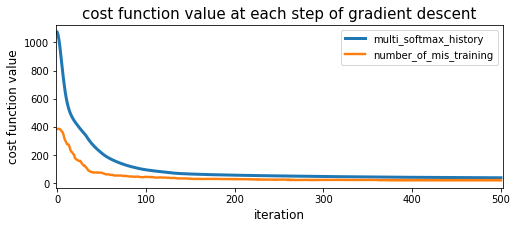

In [131]:
#initialize
scale = 0.5
W_init = initialize_network_weights(layer_sizes,scale)

#compute the weight_history, training.
weight_history = gradient_descent(g = multiclass_softmax ,w = W_init ,alpha = 10**(-2),max_its = 500,beta = 0.8,version = 'normalized')
multi_softmax_history = [multiclass_softmax(v) for v in weight_history]
number_of_mis_training = [multiclass_miss_count(v) for v in weight_history]

# plot the cost function history for our current run of gradient descent
histories = [multi_softmax_history,number_of_mis_training]
labels = ['multi_softmax_history','number_of_mis_training']
plotter_demo = plotter.Visualizer()
plotter_demo.compare_regression_histories(histories,start=0,labels=labels)

### Traning result

In [139]:
print("number of misclassifications on training set:",np.min(number_of_mis_training))
print("the accuracy of training:",1-np.min(number_of_mis_training)/P)

number of misclassifications on training set: 20
the accuracy of training: 0.95


### cross-validation accuracy

In [153]:
x_test = data[400:,:-1]
y_test = data[400:,-1:]

### preprocess the validation data in the same way

In [160]:
P_test,N = np.shape(x_test)
    
x_test_processed = np.zeros((P_test, N+3))
x_test_processed[:,0:(N-1)] = x_test[:,0:(N-1)]

x_test_processed[:,1:3] = normalize(x_test[:,1:3],x_means,x_stds)
for n in range(N):
    t = int(x[n,N-1])
    x_test_processed[n,t+N-1] = 1

In [167]:
# import plotting library and other necessities
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# our plotting function
def plot_accuracy(x,y,weight_histories,predict):
   
    fig, ax = plt.subplots(1, 1, figsize=(10,4))

    accuracy_history=[]
    
    for weight_history in weight_histories:
        all_evals = predict(x,weight_history)
        y_predict = np.argmax(all_evals,axis = 1)
        count = int(sum([abs(np.sign(a - b)) for a,b in zip(y,y_predict)]))
        
        accuracy = (len(y)-count)/len(y)
        accuracy_history.append(accuracy)
    print('Accuracy:',np.max(accuracy_history))
    
    # plot function and gradient values
    ax.plot(accuracy_history,color = 'r',linewidth = 2)
 
    # label each panel
    ax.set_xlabel('iteration')
    ax.set_ylabel('validation accuracy')
    ax.set_title('accuracy history')
    
    plt.show()

### show the accuracy on test dataset: The accuracy can reach 90%.

Accuracy: 0.9


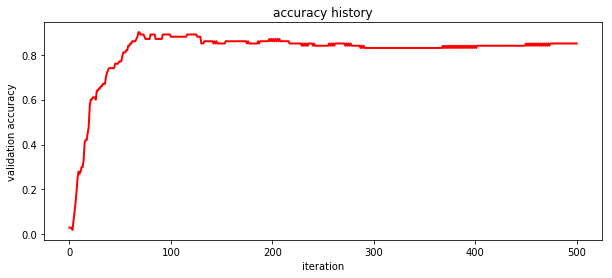

In [168]:
plot_accuracy(x_test_processed,y_test,weight_history,predict)